In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import time
import tqdm
import random
import argparse

import numpy as np
import pandas as pd
tqdm.tqdm.pandas()

import matplotlib.pyplot as plt

import gensim
from gensim import corpora, models, similarities

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.naive_bayes import MultinomialNB

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
set_seed(42)

In [2]:
df = pd.read_csv("/mnt/d/work2/teknofest-tddi/data/processed/cleaned.csv")
df = df.dropna()
df = df.reset_index(drop=True)

In [3]:
df.head()

,aspect_polarity,text
0,2,Troy Uygulamada kartlarda Troy kart geçmiyor u...
1,2,Troy Uygulamada kartlarda Troy kart geçmiyor u...
2,0,Turkcell güncellemede kötüleşen Turkcell in ar...
3,0,BiP’ten BiPten aranmıyor yardım
4,2,BİP yorumum uygulamanın gelişmesi kulanıcıya e...


In [ ]:
df["text"] = df["aspect"] + " " + df["cleaned"]

In [4]:
X = df["text"]
y = df["aspect_polarity"]

In [ ]:
def train_validate_test_split(df, split_size):
    perm = np.random.permutation(df.index)
    train_end = int(split_size * len(df.index))
    validate_end = int(((1 - split_size) / 2) * len(df.index)) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [5]:
df_train, df_validation, df_test = train_validate_test_split(df, split_size=0.9)

In [ ]:
X_train = df_train["text"]
y_train = df_train["aspect_polarity"]

In [ ]:
X_valid = df_validation["text"]
y_valid = df_validation["aspect_polarity"]

In [ ]:
X_test = df_test["text"]
y_test = df_test["aspect_polarity"]

In [6]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)
X_test_tfidf = tfidf.transform(X_test)

In [7]:
mnb = MultinomialNB()
mnb_tfidf_train_start = time.time()
mnb.fit(X_train_tfidf, y_train)
mnb_tfidf_train_time = time.time() - mnb_tfidf_train_start
print(f"MultnomialNB + TFIDF Train Time = {mnb_tfidf_train_time:.4f}")

MultnomialNB + TFIDF Train Time = 0.0249


In [8]:
mnb_tfidf_pred_train = mnb.predict(X_train_tfidf)
mnb_tfidf_test_start = time.time()
mnb_tfidf_pred_test = mnb.predict(X_test_tfidf)
mnb_tfidf_test_time = time.time() - mnb_tfidf_test_start

mnb_tfidf_train_score = accuracy_score(mnb_tfidf_pred_train, y_train)
mnb_tfidf_test_score = accuracy_score(mnb_tfidf_pred_test, y_test)
print(f"MultnomialNB + TFIDF Train Score = {mnb_tfidf_train_score * 100:.4f}%")
print(f"MultnomialNB + TFIDF Test Score = {mnb_tfidf_test_score * 100:.4f}%")
print(f"MultnomialNB + TFIDF Test Time = {mnb_tfidf_test_time:.4f}")

MultnomialNB + TFIDF Train Score = 81.5368%
MultnomialNB + TFIDF Test Score = 79.0795%
MultnomialNB + TFIDF Test Time = 0.0017


In [9]:
mnb_tfidf_precision_score = precision_score(y_test, mnb_tfidf_pred_test, average='macro')
mnb_tfidf_f1_score = f1_score(y_test, mnb_tfidf_pred_test, average='macro')
mnb_tfidf_recall_score = recall_score(y_test, mnb_tfidf_pred_test, average='macro')
mnb_tfidf_accuracy_score = accuracy_score(y_test, mnb_tfidf_pred_test)

print(f"MultnomialNB + TFIDF Precision Score = {mnb_tfidf_precision_score * 100:.4f}%")
print(f"MultnomialNB + TFIDF F1 Score = {mnb_tfidf_f1_score * 100:.4f}%")
print(f"MultnomialNB + TFIDF Recall Score = {mnb_tfidf_recall_score * 100:.4f}%")
print(f"MultnomialNB + TFIDF Accuracy Score = {mnb_tfidf_accuracy_score * 100:.4f}%")

MultnomialNB + TFIDF Precision Score = 78.8569%
MultnomialNB + TFIDF F1 Score = 76.6170%
MultnomialNB + TFIDF Recall Score = 79.0795%
MultnomialNB + TFIDF Accuracy Score = 79.0795%


In [10]:
print(classification_report(y_test, mnb_tfidf_pred_test, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.77      0.94      0.84      8977
     Neutral       0.60      0.00      0.01       829
    Positive       0.85      0.68      0.76      6446

    accuracy                           0.79     16252
   macro avg       0.74      0.54      0.54     16252
weighted avg       0.79      0.79      0.77     16252



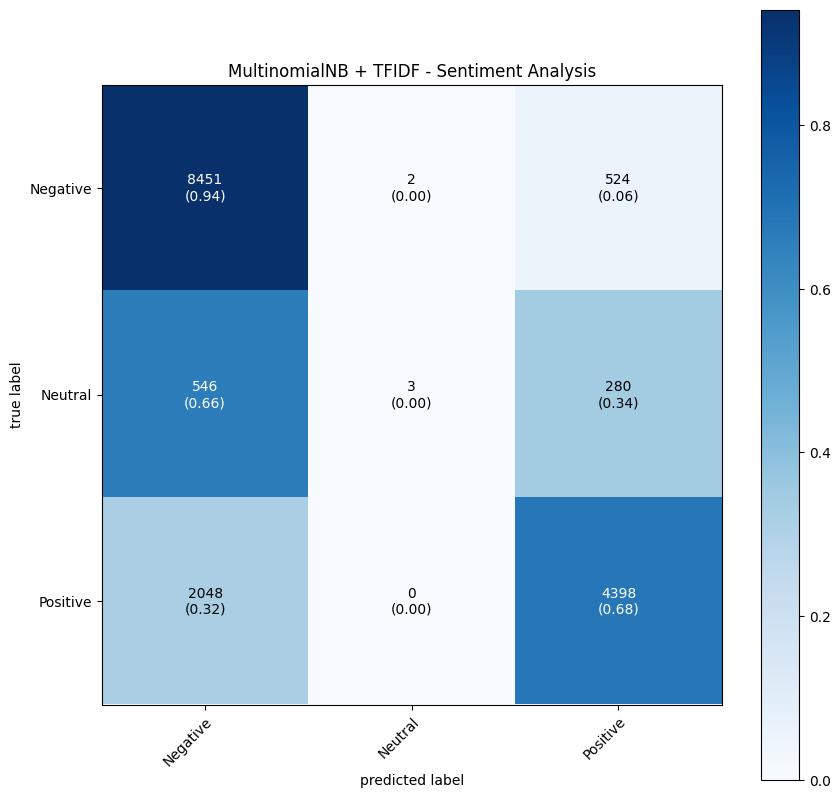

In [11]:
simplernn_cm = confusion_matrix(y_test, mnb_tfidf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=simplernn_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["Negative", "Neutral", "Positive"], figsize=(10, 10))
plt.title("MultinomialNB + TFIDF - Sentiment Analysis")
plt.savefig("./output/multinomialnb_tfidf.png")
plt.show()